In [18]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from unidip import UniDip
from sklearn.svm import LinearSVC
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

from clusterless import data_preprocess
from clusterless import viz_tools
from clusterless import init_gmm
from clusterless import split_merge
from clusterless import smooth_signals
from clusterless import decode_static

load data

In [2]:
rootpath = "../data"
sub_id = "dy009"
samp_freq = 30_000

In [3]:
# load unsorted data
spikes_indices, spikes_features, np1_channel_map, stimulus_onset_times, unsorted, trials = \
    data_preprocess.load_unsorted_data(rootpath, sub_id, roi='all', keep_active_trials=True, samp_freq=samp_freq)

In [4]:
behave_dict, behave_idx_dict = data_preprocess.load_behaviors_data(rootpath, sub_id)

In [5]:
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = data_preprocess.preprocess_static_behaviors(behave_dict, keep_active_trials = True)

choices left: 0.361, right: 0.639
stimuli left: 0.430, right: 0.570
reward wrong: 0.087, correct: 0.913


initialize gmm using k-means++ (recommended and faster than k-means)

In [6]:
trials_ids = np.arange(len(trials))
structured_unsorted = np.vstack([trials[i] for i in trials_ids])[:,1:] # follows time order

In [7]:
initial_gmm = init_gmm.initial_gaussian_mixtures('..', sub_id, trials, n_gaussians=400, seed=seed, fit_model=False)

In [8]:
initial_labels = initial_gmm.predict(structured_unsorted)
initial_probs = initial_gmm.predict_proba(structured_unsorted)

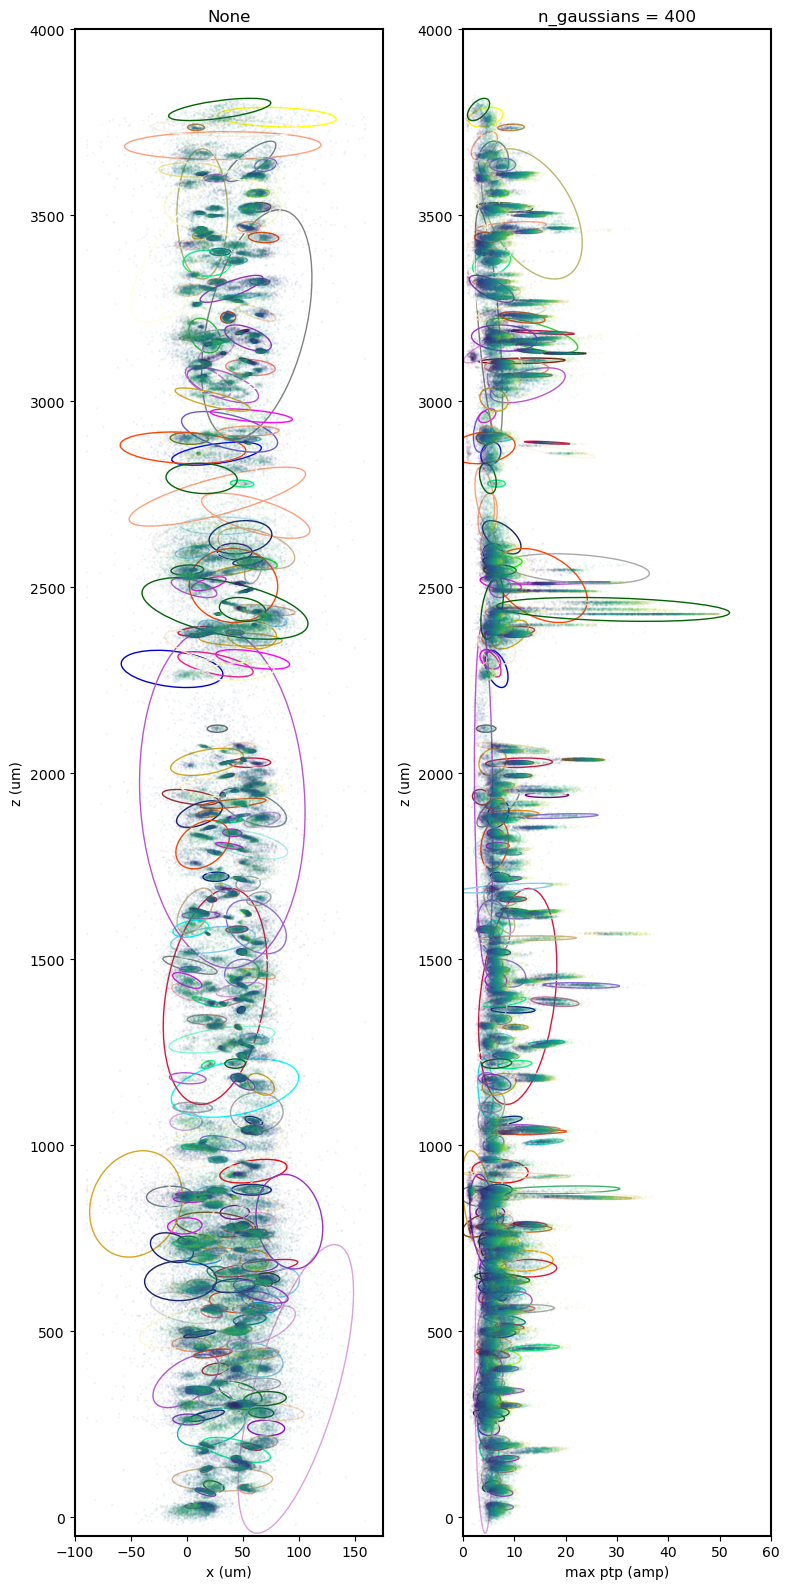

In [155]:
viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, initial_labels, initial_labels, display_all_spikes=False, n_spikes_display=1_000)

In [9]:
trials_ids = np.arange(len(trials))
spikes_times = np.vstack([trials[i] for i in trials_ids])[:,0]

clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((spikes_times, initial_labels, initial_probs), 
                                            'clusterless', stimulus_onset_times, regional=False)
clusterless_tpca_proj, clusterless_tpca_recon = smooth_signals.tpca(clusterless_neural_data, n_projs=15)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')
print(f'clusterless neural projections shape: {clusterless_tpca_proj.shape}')
print(f'clusterless neural reconstructions shape: {clusterless_tpca_recon.shape}')

clusterless neural data shape: (230, 400, 30)
clusterless neural projections shape: (230, 400, 15)
clusterless neural reconstructions shape: (230, 400, 30)


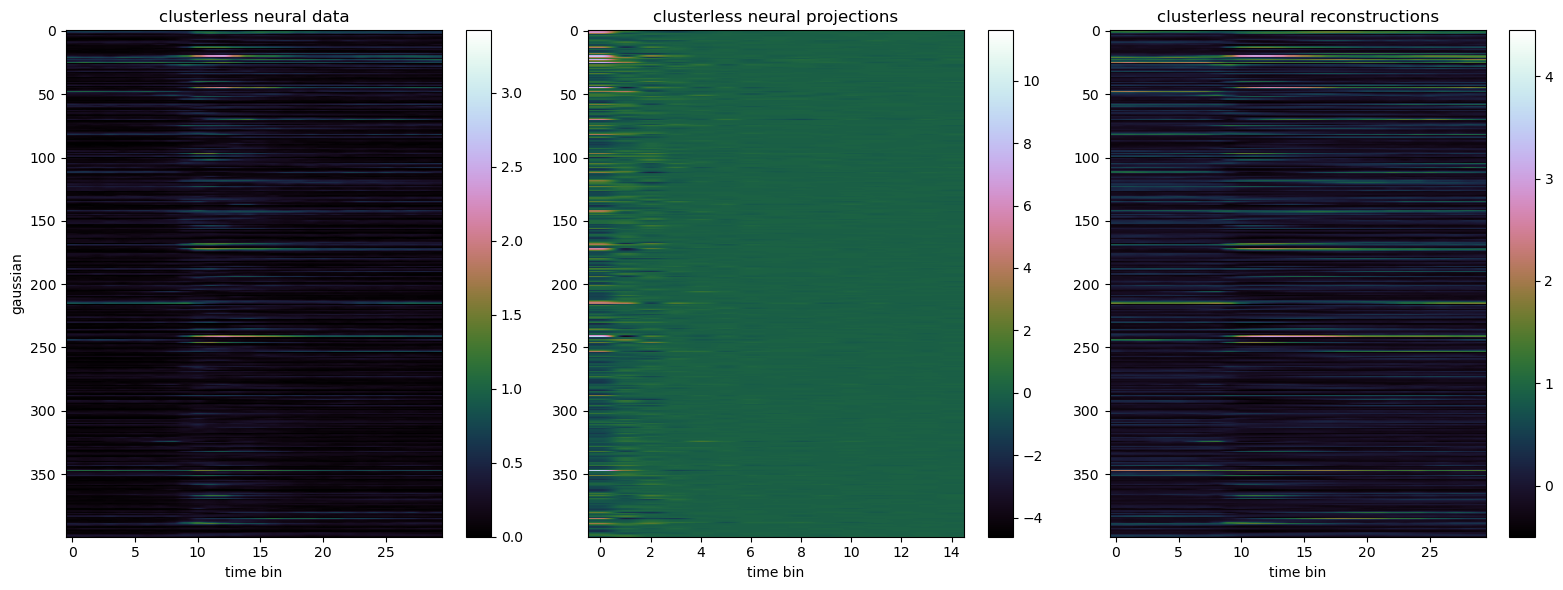

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))

p1 = axes[0].imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[0].set_title('clusterless neural data')
axes[0].set_xlabel('time bin')
axes[0].set_ylabel('gaussian')
plt.colorbar(p1, ax=axes[0]);

p2 = axes[1].imshow(clusterless_tpca_proj.mean(0), aspect='auto', cmap='cubehelix')
axes[1].set_title('clusterless neural projections')
axes[1].set_xlabel('time bin')
plt.colorbar(p2, ax=axes[1]);

p3 = axes[2].imshow(clusterless_tpca_recon.mean(0), aspect='auto', cmap='cubehelix')
axes[2].set_title('clusterless neural reconstructions')
axes[2].set_xlabel('time bin')
plt.colorbar(p3, ax=axes[2]);

plt.tight_layout()
plt.show()

In [11]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.913 auc: 0.985
choice fold 2 test accuracy: 0.957 auc: 0.981
choice fold 3 test accuracy: 0.957 auc: 0.992
choice fold 4 test accuracy: 0.935 auc: 0.982
choice fold 5 test accuracy: 0.978 auc: 1.000
choice mean of 5-fold cv accuracy: 0.948 auc: 0.988
choice sd of 5-fold cv accuracy: 0.022 auc: 0.007
stimulus fold 1 test accuracy: 0.261 auc: 0.785
stimulus fold 2 test accuracy: 0.239 auc: 0.790
stimulus fold 3 test accuracy: 0.391 auc: 0.828
stimulus fold 4 test accuracy: 0.261 auc: 0.800
stimulus fold 5 test accuracy: 0.370 auc: 0.815
stimulus mean of 5-fold cv accuracy: 0.304 auc: 0.804
stimulus sd of 5-fold cv accuracy: 0.063 auc: 0.016


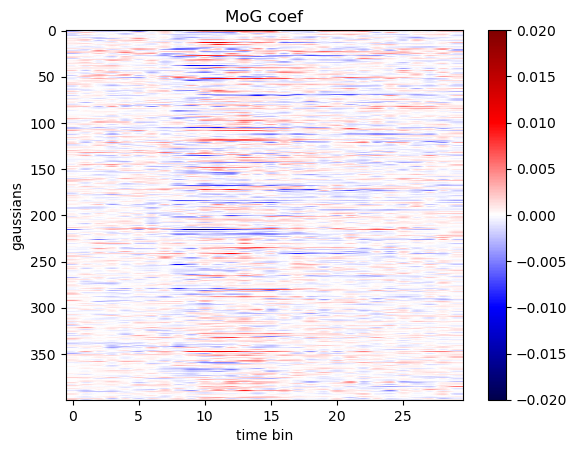

In [12]:
x = clusterless_neural_data.copy()
x = x.reshape(-1, x.shape[1]*x.shape[-1])
y = choices
decoder = LinearSVC(random_state=seed, max_iter=1e4, tol = 0.01, verbose=0)
decoder.fit(x, y.argmax(1))
coef = decoder.coef_.ravel().reshape(clusterless_neural_data.shape[1], 
                                     clusterless_neural_data.shape[-1])

p = plt.imshow(coef, aspect='auto', cmap='seismic', vmin=-0.02, vmax=0.02)
plt.title('MoG coef')
plt.xlabel('time bin')
plt.ylabel('gaussians')
plt.colorbar()
plt.show()

identify gaussians with large feature spread ...

In [13]:
from scipy.interpolate import UnivariateSpline
from clusterless.data_preprocess import load_kilosort_template_feature_mads

def calc_mad(arr):
    """ 
    median absolute deviation: a "robust" version of standard deviation.
    """
    arr = np.ma.array(arr).compressed() 
    med = np.median(arr)
    return np.median(np.abs(arr - med))

def calc_component_ptp_dependent_feature_mads(data, labels, comp_idx):
    avg_ptp = data[labels == comp_idx][:,-1].mean()
    mad_x = calc_mad(data[labels == comp_idx][:,0])
    mad_z = calc_mad(data[labels == comp_idx][:,1])
    return avg_ptp, mad_x, mad_z

def calc_smooth_envelope_feature_mads(temp_amps, mad_xs, mad_zs, use_ks_template=False):
    '''
    monotonic smoothing envelopes for x and z. 
    to do: change ad hoc smoothing params.
    to do: remove using our features.
    '''
    
    # interpolate x
    offset = mad_xs.copy()
    if use_ks_template:   
        offset[:15] = offset[:15]+1.
        offset[15:20] = offset[15:20]+2.
        offset[20:] = offset[20:]+2.
    else:
        offset[:15] = offset[:15]+6.
        offset[15:20] = offset[15:20]+3.
        offset[20:] = offset[20:]+1.
    xs = np.linspace(temp_amps.min(), temp_amps.max(), 6)
    spl1 = UnivariateSpline(temp_amps, offset)
    spl2 = UnivariateSpline(xs, spl1(xs))
    xs2 = np.linspace(xs.min(), xs.max(), 40)
    envelope_xs = spl2(xs2)
    
    # interpolate z
    offset = mad_zs.copy()
    if use_ks_template: 
        offset[:15] = offset[:15]+3.
        offset[15:20] = offset[15:20]+1
        offset[20:] = offset[20:]+2.
        zs = np.linspace(temp_amps.min(), temp_amps.max(), 6)
    else:
        offset[:15] = offset[:15]+15.
        offset[15:20] = offset[15:20]+10.
        offset[20:] = offset[20:]+3.
        zs = np.linspace(temp_amps.min(), temp_amps.max(), 6)
    spl1 = UnivariateSpline(temp_amps, offset)
    spl2 = UnivariateSpline(zs, spl1(zs))
    zs2 = np.linspace(zs.min(), zs.max(), 40)
    envelope_zs = spl2(zs2)

    return xs2, zs2, envelope_xs, envelope_zs


def split_criteria(data, labels, use_ks_template=False):
    '''
    to do: fix scale mismatch btw kilosort template features and our features.
    to do: remove using our features.
    '''
    
    avg_ptps = []
    mad_xs = []
    mad_zs = []
    for comp_idx in np.unique(labels):
        avg_ptp, mad_x, mad_z = calc_component_ptp_dependent_feature_mads(data, labels, comp_idx)
        avg_ptps.append(avg_ptp)
        mad_xs.append(mad_x)
        mad_zs.append(mad_z)
    avg_ptps = np.array(avg_ptps)
    mad_xs = np.array(mad_xs)
    mad_zs = np.array(mad_zs)
    
    if use_ks_template:
        binned_ptps, binned_xs, binned_zs = load_kilosort_template_feature_mads('../data')
        xs, zs, envelope_xs, envelope_zs = \
        calc_smooth_envelope_feature_mads(binned_ptps, binned_xs, binned_zs, use_ks_template=use_ks_template)
        closest_bin_ids = [np.argmin(np.abs(binned_ptps - ptp)) for ptp in avg_ptps]    
    else:
        for bin_size in range(200):
            ptp_bins = np.linspace(np.min(avg_ptps), np.max(avg_ptps), bin_size) 
            ptp_masks = np.digitize(avg_ptps, ptp_bins, right=True)
            if len(np.unique(ptp_masks)) == 40:
                break
        binned_ptps = np.array([avg_ptps[ptp_masks == bin].mean() for bin in np.unique(ptp_masks)])
        binned_xs = np.array([mad_xs[ptp_masks == bin].mean() for bin in np.unique(ptp_masks)])
        binned_zs = np.array([mad_zs[ptp_masks == bin].mean() for bin in np.unique(ptp_masks)])
        closest_ptp_bins = [np.argmin(np.abs(ptp_bins - ptp)) for ptp in avg_ptps]
        closest_bin_ids = [np.argmin(np.abs(np.unique(ptp_masks) - bin_id)) for bin_id in closest_ptp_bins]
        xs, zs, envelope_xs, envelope_zs = \
        calc_smooth_envelope_feature_mads(binned_ptps, binned_xs, binned_zs, use_ks_template=use_ks_template)
        
    fig, axes = plt.subplots(1,2, figsize=(10,3))
    axes[0].plot(binned_ptps, binned_xs, label='x', linestyle='dashed')
    axes[0].plot(xs, envelope_xs, label='envelope x', linewidth=2)
    axes[0].set_xlabel('template amplitude')
    axes[0].set_ylabel('feature MAD')
    axes[0].legend();
    axes[1].plot(binned_ptps, binned_zs, label='z', linestyle='dashed')
    axes[1].plot(zs, envelope_zs, label='envelope z', linewidth=2)
    axes[1].legend();
    axes[1].set_xlabel('template amplitude')
    plt.tight_layout()
    plt.show()
          
    split_ids = []
    for i in range(len(avg_ptps)):
        if np.logical_or(mad_xs[i] > envelope_xs[closest_bin_ids[i]], 
                         mad_xs[i] > envelope_zs[closest_bin_ids[i]]):
            split_ids.append(i)
            
    residual_labels = list(set(np.unique(labels)).difference(set(split_ids)))
            
    return split_ids, residual_labels

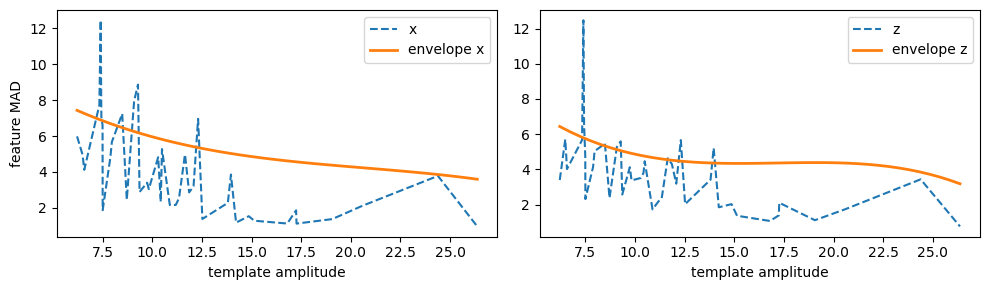

114 286


In [14]:
# plot smooth envelope for kilosort template feature MADs
# split_ids, residual_ids = split_merge.split_criteria(structured_unsorted, initial_labels, use_ks_template=True)
split_ids, residual_ids = split_criteria(structured_unsorted, initial_labels, use_ks_template=True)
print(len(split_ids), len(residual_ids))

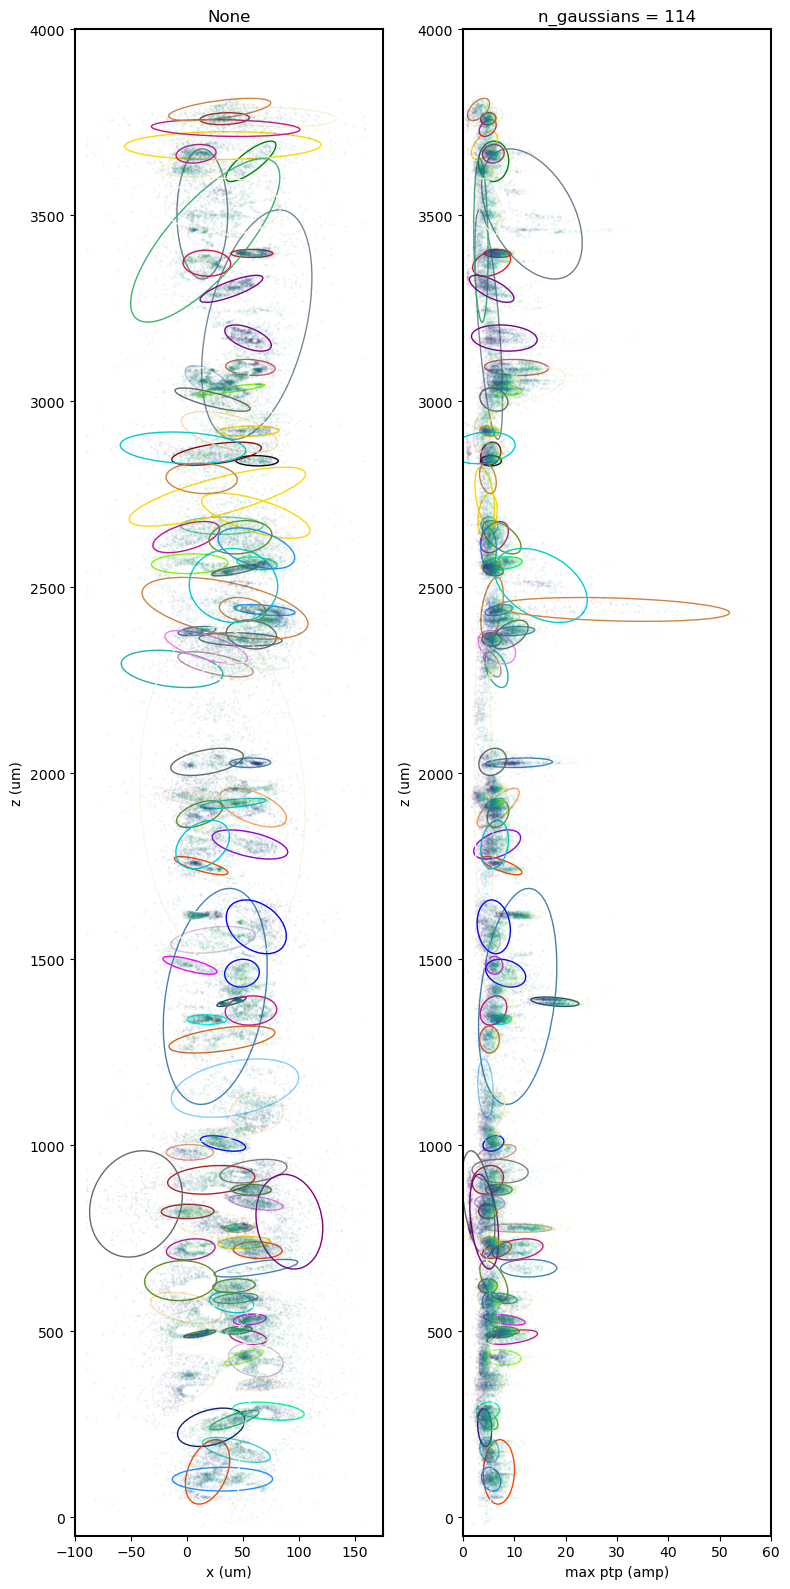

In [15]:
viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, initial_labels, split_ids, display_all_spikes=False, n_spikes_display=1_000)

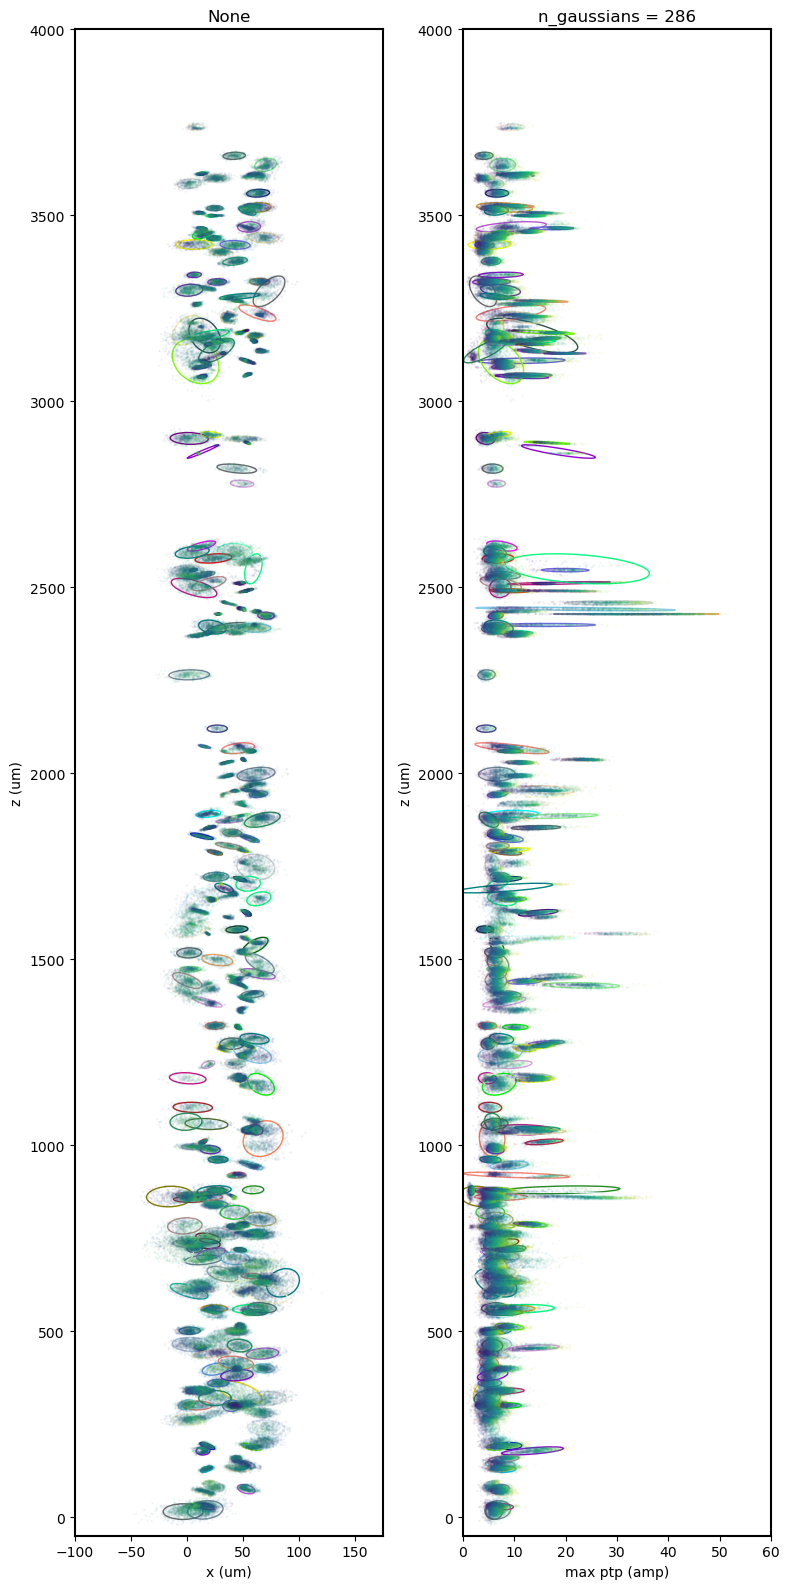

In [16]:
viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, initial_labels, residual_ids, display_all_spikes=False, n_spikes_display=1_000)

identify multi-modal gaussians (dip test)

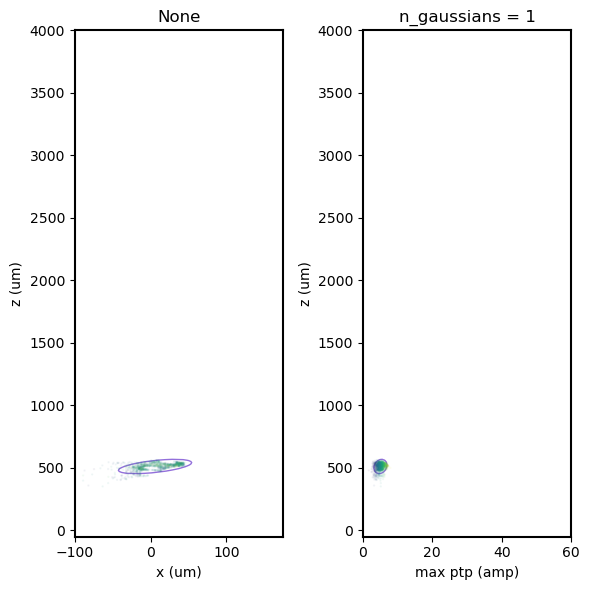

In [146]:
# small sread & multi-modal: -1, 47, 64, 102, 104, 113
# large spread & multi-modal: 19, 28, 46, 52, 93, 106, 112
idx = split_ids[102] 
sub_spike_train = structured_unsorted[initial_labels == idx]
viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, initial_labels, idx, display_all_spikes=True, figure_size=(6,6))

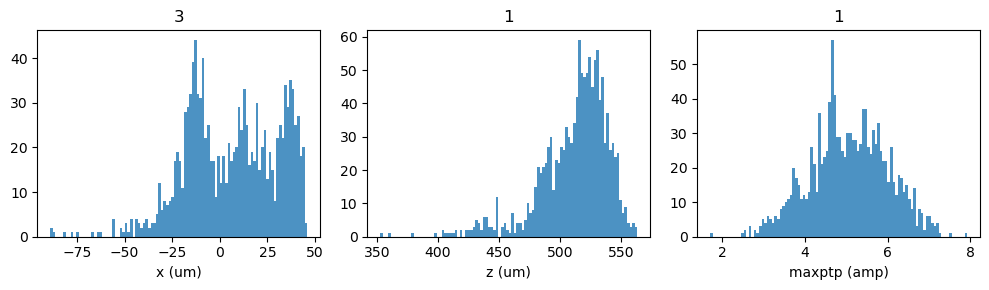

In [147]:
n_modes_x = len(UniDip(np.msort(sub_spike_train[:,0])).run())
n_modes_z = len(UniDip(np.msort(sub_spike_train[:,1])).run())
n_modes_ptp = len(UniDip(np.msort(sub_spike_train[:,2])).run())
n_gaussians = np.max([n_modes_x, n_modes_z, n_modes_ptp])

fig, axes = plt.subplots(1,3, figsize=(10,3))
axes[0].hist(sub_spike_train[:,0], 100, alpha=.8)
axes[0].set_xlabel('x (um)')
dat = np.msort(sub_spike_train[:,0])
axes[0].set_title(n_modes_x)
axes[1].hist(sub_spike_train[:,1], 100, alpha=.8)
axes[1].set_xlabel('z (um)')
axes[1].set_title(n_modes_z)
axes[2].hist(sub_spike_train[:,2], 100, alpha=.8)
axes[2].set_xlabel('maxptp (amp)')
axes[2].set_title(n_modes_ptp)
plt.tight_layout()
plt.show()

In [151]:
sub_gmm = GaussianMixture(n_components=n_gaussians, 
                          max_iter=1000, covariance_type='full',
                          init_params='kmeans', warm_start=False, verbose=0).fit(sub_spike_train)

In [152]:
sub_labels = sub_gmm.predict(sub_spike_train)

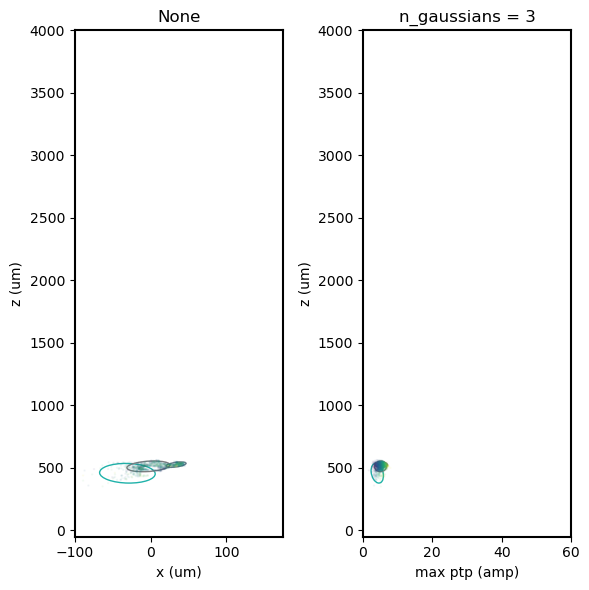

In [154]:
viz_tools.plot_gmm_cluster_bounds(sub_id, sub_spike_train, sub_labels, sub_labels, figure_size=(6,6), display_all_spikes=True)

iterate to do so ...

In [116]:
multi_modal_dict = {}
sub_spike_train_lst = []
sub_weights_lst = []
sub_means_lst = []
sub_covs_lst = []
for label in np.unique(initial_labels):
    if label % 10 == 0:
        print(f'checking multi-modality for {label} ...')
    sub_spike_train = structured_unsorted[initial_labels == label]
    sub_spike_train_lst.append(sub_spike_train)
    n_modes_x = len(UniDip(np.msort(sub_spike_train[:,0])).run())
    n_modes_z = len(UniDip(np.msort(sub_spike_train[:,1])).run())
    n_modes_ptp = len(UniDip(np.msort(sub_spike_train[:,2])).run())
    n_gaussians = np.max([n_modes_x, n_modes_z, n_modes_ptp])
    if n_gaussians > 1:
        multi_modal_dict.update({label: n_gaussians})
        sub_gmm = GaussianMixture(n_components=n_gaussians, 
                          covariance_type='full',
                          # covariance_type='tied',        
                          init_params='kmeans', warm_start=True, verbose=0)
        sub_gmm.fit(sub_spike_train)
        sub_labels = sub_gmm.predict(sub_spike_train)
        sub_weights = [np.sum(sub_labels == i)/len(structured_unsorted) for i in range(n_gaussians)]
        # sub_weights = np.ones(n_gaussians) * (initial_gmm.weights_[initial_labels[idx]] / n_gaussians)
        sub_weights_lst.append(sub_weights)
        sub_means_lst.append(sub_gmm.means_)
        sub_covs_lst.append(sub_gmm.covariances_)
        # sub_covs_lst.append([sub_gmm.covariances_ for i in range(n_gaussians)])

checking multi-modality for 0 ...
checking multi-modality for 10 ...
checking multi-modality for 20 ...
checking multi-modality for 30 ...
checking multi-modality for 40 ...
checking multi-modality for 50 ...
checking multi-modality for 60 ...
checking multi-modality for 70 ...
checking multi-modality for 80 ...
checking multi-modality for 90 ...
checking multi-modality for 100 ...
checking multi-modality for 110 ...
checking multi-modality for 120 ...
checking multi-modality for 130 ...
checking multi-modality for 140 ...
checking multi-modality for 150 ...
checking multi-modality for 160 ...
checking multi-modality for 170 ...
checking multi-modality for 180 ...
checking multi-modality for 190 ...
checking multi-modality for 200 ...
checking multi-modality for 210 ...
checking multi-modality for 220 ...
checking multi-modality for 230 ...
checking multi-modality for 240 ...
checking multi-modality for 250 ...
checking multi-modality for 260 ...
checking multi-modality for 270 ...
che

In [117]:
multi_modal_ids = list(multi_modal_dict.keys())
uni_modal_ids = list(set(np.unique(initial_labels)).difference(set(multi_modal_ids)))

In [140]:
# viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, initial_labels, multi_modal_ids, figure_size=(8,12), display_all_spikes=True)

In [141]:
# viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, initial_labels, uni_modal_ids, figure_size=(8,12), display_all_spikes=True)

In [83]:
multi_modal_dict = {}
sub_spike_train_lst = []
sub_weights_lst = []
sub_means_lst = []
sub_covs_lst = []
for idx in range(len(split_ids)):
    sub_spike_train = structured_unsorted[initial_labels == split_ids[idx]]
    sub_spike_train_lst.append(sub_spike_train)
    n_modes_x = len(UniDip(np.msort(sub_spike_train[:,0])).run())
    n_modes_z = len(UniDip(np.msort(sub_spike_train[:,1])).run())
    n_modes_ptp = len(UniDip(np.msort(sub_spike_train[:,2])).run())
    n_gaussians = np.max([n_modes_x, n_modes_z, n_modes_ptp])
    if n_gaussians > 1:
        multi_modal_dict.update({split_ids[idx]: n_gaussians})
        sub_gmm = GaussianMixture(n_components=n_gaussians, 
                          covariance_type='full',
                          # covariance_type='tied',        
                          init_params='kmeans', warm_start=True, verbose=0)
        sub_gmm.fit(sub_spike_train)
        sub_labels = sub_gmm.predict(sub_spike_train)
        sub_weights = [np.sum(sub_labels == i)/len(structured_unsorted) for i in range(n_gaussians)]
        # sub_weights = np.ones(n_gaussians) * (initial_gmm.weights_[initial_labels[idx]] / n_gaussians)
        sub_weights_lst.append(sub_weights)
        sub_means_lst.append(sub_gmm.means_)
        sub_covs_lst.append(sub_gmm.covariances_)
        # sub_covs_lst.append([sub_gmm.covariances_ for i in range(n_gaussians)])

In [84]:
multi_modal_ids = list(multi_modal_dict.keys())
uni_modal_ids = list(set(np.unique(initial_labels)).difference(set(multi_modal_ids)))

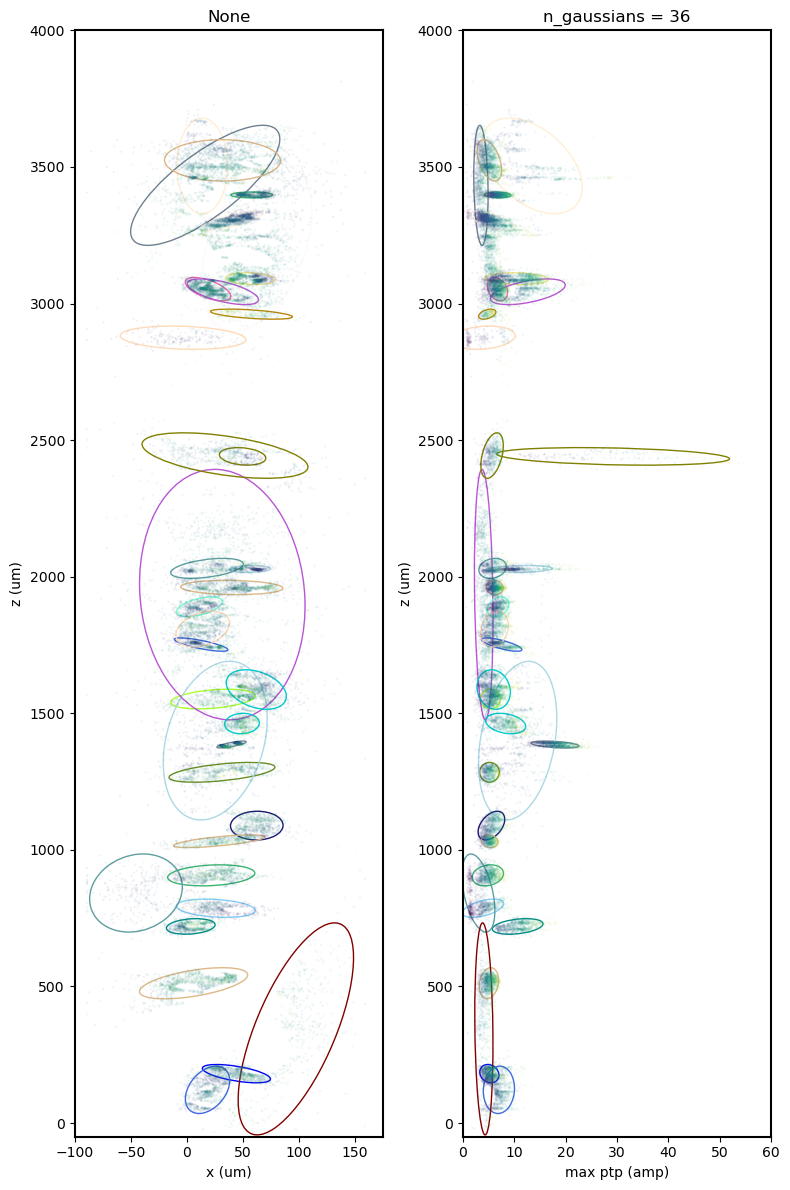

In [85]:
viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, initial_labels, multi_modal_ids, figure_size=(8,12), display_all_spikes=True)

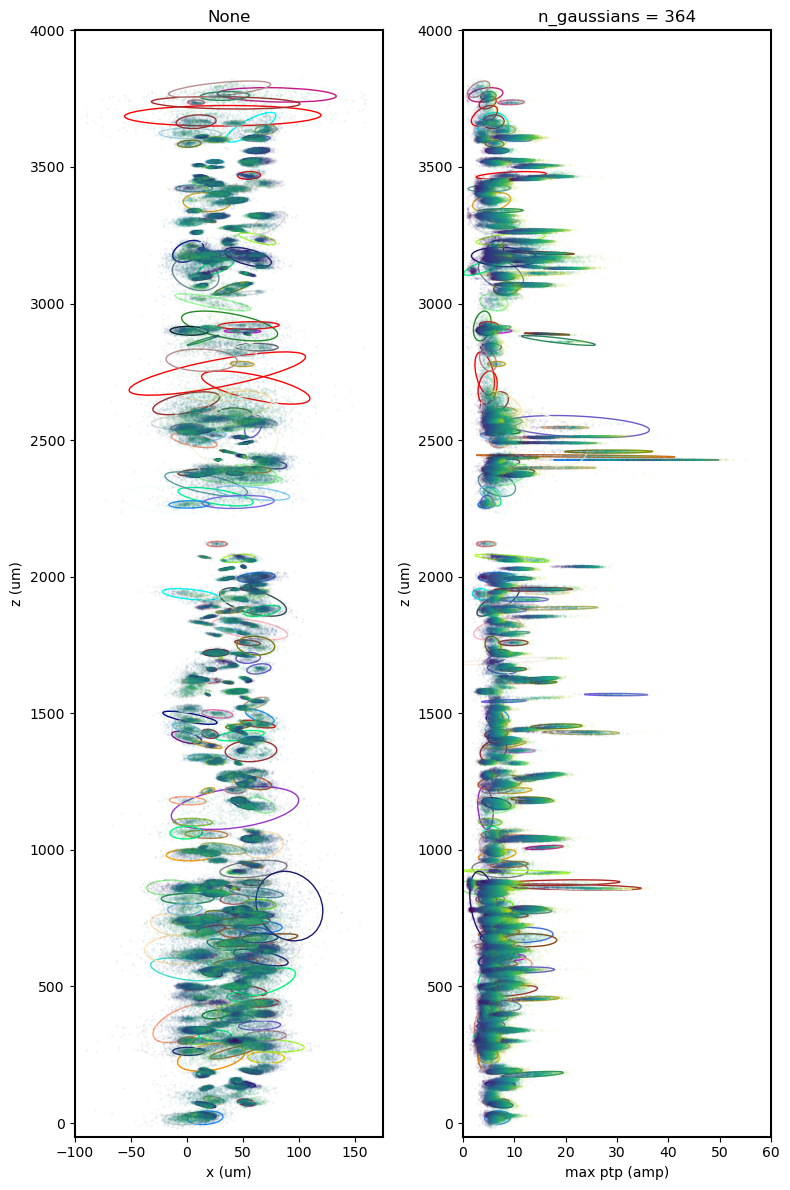

In [86]:
viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, initial_labels, uni_modal_ids, figure_size=(8,12), display_all_spikes=True)

In [120]:
residual_ids = set(np.unique(initial_labels)).difference(set(multi_modal_ids))
print(f'keep {len(residual_ids)} gaussians and split {len(multi_modal_ids)} gaussians ...')

residual_weights = np.vstack([initial_gmm.weights_[i] for i in residual_ids]).squeeze()
residual_means = np.vstack([initial_gmm.means_[i] for i in residual_ids])
residual_covariances = np.stack([initial_gmm.covariances_[i] for i in residual_ids])

residual_gmm = GaussianMixture(n_components=len(residual_ids), covariance_type='full')
residual_gmm.weights_ = residual_weights
residual_gmm.means_ = residual_means
residual_gmm.covariances_ = residual_covariances
residual_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(residual_covariances))

residual_spikes_train = np.vstack([structured_unsorted[initial_labels == idx] for idx in residual_ids])
residual_vars = np.vstack([np.var(structured_unsorted[initial_labels == i], axis=0) for i in residual_ids])
empirical_cov_prior = np.zeros((3, 3))
empirical_cov_prior[range(3), range(3)] = np.mean(residual_vars, axis=0)

keep 335 gaussians and split 65 gaussians ...


In [121]:
sub_weights = np.hstack(sub_weights_lst)
sub_means = np.vstack(sub_means_lst)
sub_covs = np.vstack(sub_covs_lst)

In [122]:
post_split_weights = np.hstack([residual_gmm.weights_, sub_weights])
post_split_means = np.vstack([residual_gmm.means_, sub_means])
post_split_covariances = np.vstack([residual_gmm.covariances_, sub_covs])

post_split_gmm = GaussianMixture(n_components=len(post_split_weights), covariance_type='full')
post_split_gmm.weights_ = post_split_weights
post_split_gmm.means_ = post_split_means
post_split_gmm.covariances_ = post_split_covariances
post_split_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(post_split_covariances))

In [123]:
post_split_precisions = []
for idx in range(len(post_split_weights)):
    tmp_cov = np.zeros((3, 3))
    tmp_cov[range(3), range(3)] = np.diag(post_split_covariances[idx])
    post_split_precisions.append(np.linalg.cholesky(np.linalg.inv(tmp_cov)))
    # post_split_precisions.append(np.linalg.cholesky(np.linalg.inv(empirical_cov_prior)))
post_split_precisions = np.stack(post_split_precisions)

In [124]:
tmp_labels = post_split_gmm.predict(structured_unsorted)
tmp_weights = np.array([np.sum(tmp_labels == i)/len(structured_unsorted) for i in np.unique(tmp_labels)])

In [125]:
shuffle_idx = np.arange(len(post_split_weights))
random.shuffle(shuffle_idx)

In [126]:
post_split_gmm = GaussianMixture(n_components=len(post_split_weights), 
                weights_init=tmp_weights[shuffle_idx],
                means_init=post_split_means[shuffle_idx],
                covariance_type='full',
                precisions_init=post_split_precisions[shuffle_idx],
                warm_start=True, verbose=1, verbose_interval=1)

In [127]:
post_split_gmm.fit(structured_unsorted)

Initialization 0
  Iteration 1
  Iteration 2
  Iteration 3
  Iteration 4
  Iteration 5
  Iteration 6
  Iteration 7
  Iteration 8
  Iteration 9
  Iteration 10
  Iteration 11
  Iteration 12
  Iteration 13
  Iteration 14
Initialization converged: True


GaussianMixture(means_init=array([[  23.29337568,  142.65560904,    6.79766209],
       [  44.84126068, 1387.81558791,   18.41074565],
       [  32.07014713, 1941.19661034,   16.45403399],
       ...,
       [  43.84071609,  775.56786321,    5.7542212 ],
       [  10.15872162, 2380.56979485,   10.22774947],
       [  55.92835447, 1825.0602024 ,    8.63152635]]),
                n_components=518,
                precisions_init=array([[[0.11973561, 0.        , 0.        ],
        [0.        , 0.06222878, 0....
       6.11316571e-04, 8.18252926e-04, 1.77319776e-03, 9.01786867e-04,
       7.05292255e-03, 5.50564614e-05, 2.43957079e-03, 3.51222253e-04,
       5.14113439e-03, 6.13215070e-04, 1.12201271e-03, 2.21554794e-03,
       1.95925062e-03, 5.99925579e-04, 4.59436677e-04, 7.74587456e-04,
       8.31542416e-04, 9.77726814e-04, 4.68549471e-03, 3.49323755e-04,
       1.00430579e-03, 2.23073593e-03, 3.32237267e-04, 1.71054730e-03,
       1.16188118e-03, 1.36312204e-03]))

In [128]:
post_split_labels = post_split_gmm.predict(structured_unsorted)
post_split_probs = post_split_gmm.predict_proba(structured_unsorted)

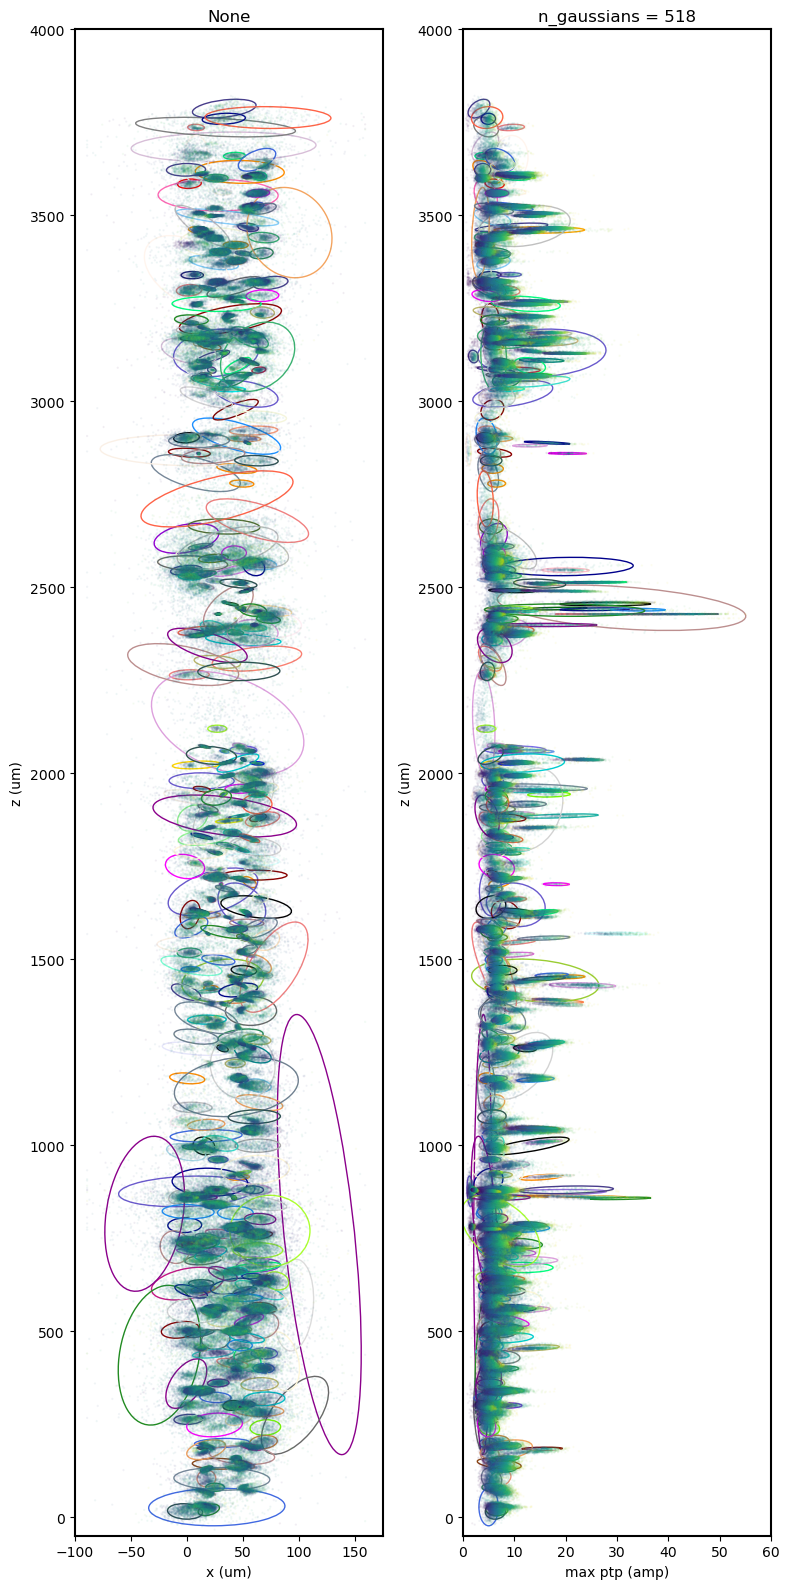

In [129]:
viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, post_split_labels, post_split_labels, display_all_spikes=False, n_spikes_display=5_000)

In [130]:
trials_ids = np.arange(len(trials))
spikes_times = np.vstack([trials[i] for i in trials_ids])[:,0]

clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((spikes_times, post_split_labels, post_split_probs), 
                                            'clusterless', stimulus_onset_times, regional=False)
clusterless_tpca_proj, clusterless_tpca_recon = smooth_signals.tpca(clusterless_neural_data, n_projs=15)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')
print(f'clusterless neural projections shape: {clusterless_tpca_proj.shape}')
print(f'clusterless neural reconstructions shape: {clusterless_tpca_recon.shape}')

clusterless neural data shape: (230, 518, 30)
clusterless neural projections shape: (230, 518, 15)
clusterless neural reconstructions shape: (230, 518, 30)


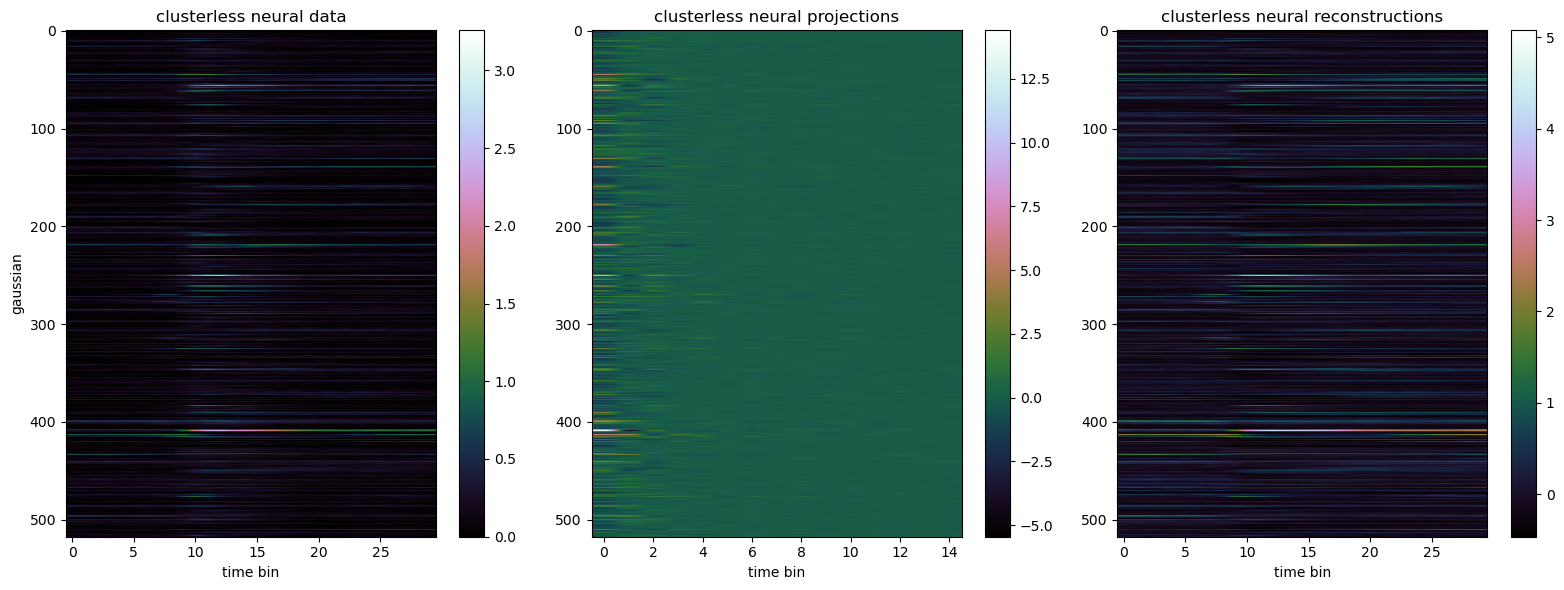

In [131]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))

p1 = axes[0].imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[0].set_title('clusterless neural data')
axes[0].set_xlabel('time bin')
axes[0].set_ylabel('gaussian')
plt.colorbar(p1, ax=axes[0]);

p2 = axes[1].imshow(clusterless_tpca_proj.mean(0), aspect='auto', cmap='cubehelix')
axes[1].set_title('clusterless neural projections')
axes[1].set_xlabel('time bin')
plt.colorbar(p2, ax=axes[1]);

p3 = axes[2].imshow(clusterless_tpca_recon.mean(0), aspect='auto', cmap='cubehelix')
axes[2].set_title('clusterless neural reconstructions')
axes[2].set_xlabel('time bin')
plt.colorbar(p3, ax=axes[2]);

plt.tight_layout()
plt.show()

In [132]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.913 auc: 0.985
choice fold 2 test accuracy: 0.935 auc: 0.981
choice fold 3 test accuracy: 0.957 auc: 0.988
choice fold 4 test accuracy: 0.935 auc: 0.982
choice fold 5 test accuracy: 1.000 auc: 1.000
choice mean of 5-fold cv accuracy: 0.948 auc: 0.987
choice sd of 5-fold cv accuracy: 0.029 auc: 0.007
stimulus fold 1 test accuracy: 0.196 auc: 0.776
stimulus fold 2 test accuracy: 0.217 auc: 0.786
stimulus fold 3 test accuracy: 0.326 auc: 0.823
stimulus fold 4 test accuracy: 0.261 auc: 0.803
stimulus fold 5 test accuracy: 0.370 auc: 0.815
stimulus mean of 5-fold cv accuracy: 0.274 auc: 0.801
stimulus sd of 5-fold cv accuracy: 0.065 auc: 0.017


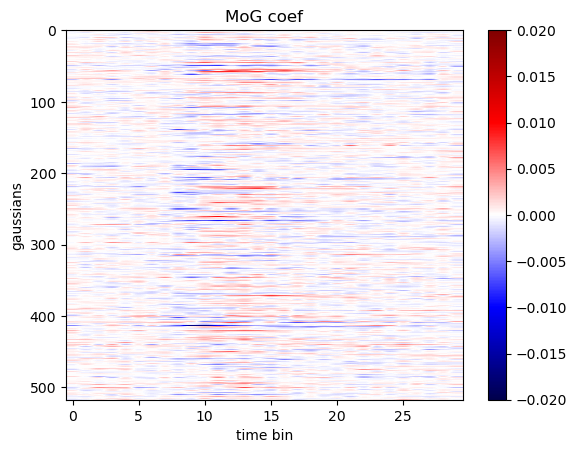

In [133]:
x = clusterless_neural_data.copy()
x = x.reshape(-1, x.shape[1]*x.shape[-1])
y = choices
decoder = LinearSVC(random_state=seed, max_iter=1e4, tol = 0.01, verbose=0)
decoder.fit(x, y.argmax(1))
coef = decoder.coef_.ravel().reshape(clusterless_neural_data.shape[1], 
                                     clusterless_neural_data.shape[-1])

p = plt.imshow(coef, aspect='auto', cmap='seismic', vmin=-0.02, vmax=0.02)
plt.title('MoG coef')
plt.xlabel('time bin')
plt.ylabel('gaussians')
plt.colorbar()
plt.show()